# Outlier detection v1
- Working autoencoder
- Working SHAP DeepExplainer
- Successfuly explained 2018-01 data, but the results are not satisfactory enough
- More/better features are needed

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [4]:
# from google.colab import drive
# drive.mount('/content/drive')
# file_prefix = '/content/drive/MyDrive/DP/analysis/outlier_detection/'

file_prefix = 'tmp_v1/'

In [5]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import Dataset, DataLoader, TensorDataset

In [6]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [7]:
class MyDataset(Dataset):
    """Single PD DF dataset"""

    def __init__(self, df):
        self.df = df.astype('float32')

    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self,idx):
        tensor = torch.tensor(self.df.iloc[idx])
        return tensor, torch.tensor(0).float()

In [8]:
def get_datasets_by_vehicle_type(path):
    df = pd.read_csv(path, index_col=0)
    df['DatKont'] = pd.to_datetime(df['DatKont'])
    df['DatPrvReg'] = pd.to_datetime(df['DatPrvReg'])
    
    def stk_result_to_ordinal(text):
        if text == 'způsobilé':
            return 0
        if text == 'částečně způsobilé':
            return 1
        if text == 'nezpůsobilé':
            return 2
        return 3

    dts_by_category = {
        # 'MOTOCYKL' : None,
        'NÁKLADNÍ AUTOMOBIL': None,
        # 'OSOBNÍ AUTOMOBIL': None
    }
    for vehicle_type in dts_by_category.keys():
        df_type = df[df['DrVoz'] == vehicle_type]

        df_type = df_type.drop(['VIN', 'DatKont', 'TypMot', 'DrVoz', 'Ct', 'DatPrvReg', 'Zavady', 'VyslEmise'], axis=1)

        dummies = pd.get_dummies(df_type[['DrTP']], drop_first=True)
        base = pd.concat([df_type, dummies], axis=1)
        base = base.drop(['DrTP', 'TZn', 'ObchOznTyp', 'STK'], axis=1)

        base['VyslSTK'] = base['VyslSTK'].apply(stk_result_to_ordinal).astype('uint8')

        dts_by_category[vehicle_type] = MyDataset(base)
    
    return dts_by_category

In [9]:
# define autoencoder architecture
class AE(nn.Module):
    def __init__(self, original_dim, encoding_dim):
        super(AE, self).__init__()

        mid_dim = (original_dim + encoding_dim) // 2

        self.name = f'ae-with-in-out-{original_dim}-{mid_dim}-{encoding_dim}'

        # input
        self.layer_input = nn.Linear(original_dim, mid_dim)
        # encoder
        self.layer_encoder = nn.Linear(mid_dim, encoding_dim)
        # decoder
        self.layer_decoder = nn.Linear(encoding_dim, mid_dim)
        # output
        self.layer_output = nn.Linear(mid_dim, original_dim)

    def forward(self, x):
        input = F.relu(self.layer_input(x))
        # pass input into encoder
        encoded = F.relu(self.layer_encoder(input))
        # pass encoded into decoder
        decoded = F.relu(self.layer_decoder(encoded))
        # pass to output
        return self.layer_output(decoded)

In [10]:
def train_and_eval(dataset, name, n_epochs):
    dataloader = torch.utils.data.DataLoader(dataset, 
                                          batch_size = 2048,
                                          shuffle = True)
    
    original_dim = len(dataset.__getitem__(0)[0])
    latent_dim = 4
    model = AE(original_dim, latent_dim).to(device)

    # what are we going to optimize?
    criterion = nn.MSELoss() # if you have a regression task and don't know what to do - use `MSELoss`

    # how are we going to optimize it?
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001) # if you just don't know what to do - use `Adam` optimizer

    for epoch in range(1, n_epochs + 1):
        # monitor training loss
        train_loss = 0.0

        for data, _ in dataloader: # returns batch shape = (batch_size, 28, 28)
            optimizer.zero_grad() # clear the gradients of all optimized variables
            # print(type(data))
            data = data.to(device) # send to GPU
            outputs = model(data)  # forward pass: compute predicted outputs by passing inputs to the model
            loss = criterion(outputs, data) # calculate the loss
            loss.backward() # backward pass: compute gradient of the loss with respect to model parameters
            optimizer.step() # perform a single optimization step (parameter update)
            train_loss += loss.item()
      
        train_loss = train_loss/len(dataloader)
        print('    Epoch: {} \tTraining Loss: {:.4f}'.format(
            epoch, 
            train_loss
            ))
    
    # save the model
    torch.save(model.state_dict(), f'{file_prefix}{name}.{model.name}.pth')

    # evaluate
    model.eval()

    err_list = []
    for i in range(len(dataset)):
        X = dataset[i][0].to(device)
        with torch.no_grad():
            Y = model(X)                           # Y should be same as X
        errs = X - Y                               # get errors of each feature
        sse_err = torch.sum((errs)*(errs)).item()  # SSE all features
        sse_err = sse_err / original_dim           # sort of norm'ed SSE 
        err_list.append((i, sse_err, errs))        # idx of data item, err

    err_list.sort(key=lambda x: x[1], reverse=True)  # sort by descending error
    
    errs = [tupl[1] for tupl in err_list]
    hist = np.histogram(errs, bins=100)

    return err_list, hist

## Plain evaluation

In [63]:
# run model on all datasets

results = {}

epochs_per_vt = {
    'MOTOCYKL' : 200,
    'NÁKLADNÍ AUTOMOBIL': 100,
    'OSOBNÍ AUTOMOBIL': 70
}

for month in range(1, 2):
    name = f'2018-{str(month).zfill(2)}'

    print(f'-------- {name} --------')

    print('  Loading dataset...')
    path = f'{file_prefix}{name}.csv'
    dts_by_vt = get_datasets_by_vehicle_type(path)

    results[name] = {}

    for vehicle_type, dataset in dts_by_vt.items():
        print(f'  Vehicle type: {vehicle_type}')

        err_list, hist = train_and_eval(dataset, name + '-' + vehicle_type, epochs_per_vt[vehicle_type])

        results[name][vehicle_type] = {
            'dataset': dataset,
            'err_list': err_list,
            'hist': hist
        }

-------- 2018-01 --------
  Loading dataset...
  Vehicle type: NÁKLADNÍ AUTOMOBIL
    Epoch: 1 	Training Loss: 5759988019.2000
    Epoch: 2 	Training Loss: 5705035750.4000
    Epoch: 3 	Training Loss: 5454364288.0000
    Epoch: 4 	Training Loss: 5247204889.6000
    Epoch: 5 	Training Loss: 4761014425.6000
    Epoch: 6 	Training Loss: 4097928102.4000
    Epoch: 7 	Training Loss: 3227379366.4000
    Epoch: 8 	Training Loss: 2157074950.4000
    Epoch: 9 	Training Loss: 1103371929.6000
    Epoch: 10 	Training Loss: 341737760.0000
    Epoch: 11 	Training Loss: 44630825.7750
    Epoch: 12 	Training Loss: 1884916.8094
    Epoch: 13 	Training Loss: 748321.0281
    Epoch: 14 	Training Loss: 467976.3547
    Epoch: 15 	Training Loss: 241630.7266
    Epoch: 16 	Training Loss: 133457.0867
    Epoch: 17 	Training Loss: 79931.1607
    Epoch: 18 	Training Loss: 52166.7890
    Epoch: 19 	Training Loss: 38680.6565
    Epoch: 20 	Training Loss: 33239.8953
    Epoch: 21 	Training Loss: 29402.6684
    Epoc

In [65]:
# save the results
import pickle
# with open(f'{file_prefix}results.pickle', 'wb') as file:
with open(f'{file_prefix}results-NÁKLADNÍ AUTOMOBIL.pickle', 'wb') as file:
    pickle.dump(results, file, protocol=pickle.HIGHEST_PROTOCOL)

In [66]:
for name, vts in results.items():
    print(name)
    for vt, data in vts.items():
        print('  ' + vt)
        print('    ' + str(data['hist'][0]))

2018-01
  NÁKLADNÍ AUTOMOBIL
    [36563  1751   587   147    70    24    18    10     1     4     1     3
     0     0     1     0     0     0     2     2     0     0     0     0
     0     0     0     0     1     0     0     0     0     0     0     0
     0     0     0     0     0     0     1     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     1]


In [67]:
# display the items with the largest error
for name, vts in results.items():
    print(name)
    for vt, data in vts.items():
        print('  ' + vt)
        n = 100
        err_items_indices = data['err_list'][-n:]
        err_items_df = data['dataset'].df.iloc[[tupl[0] for tupl in err_items_indices]]
        display(err_items_df.head(n))

2018-01
  NÁKLADNÍ AUTOMOBIL


,Km,VyslSTK,DTKont,ZavA,ZavB,ZavC,StariDnu,DrTP_ADR - opakovaná,DrTP_Evidenční kontrola,DrTP_Na žádost zákazníka,DrTP_Nařízená technická prohlídka,DrTP_Před registrací,DrTP_Před registrací - opakovaná,DrTP_Před schvál. tech. způsob. vozidla,DrTP_Před schvál. tech. způsob. vozidla - opakovaná,DrTP_TSK - Opakovaná,DrTP_TSK - Opakovaná po DN,DrTP_Technická silniční kontrola,DrTP_opakovaná,DrTP_pravidelná
1146719,1.0,0.0,2.0,0.0,0.0,0.0,1823.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1909579,0.0,0.0,1.0,0.0,0.0,0.0,2846.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3875644,518.0,0.0,2.0,0.0,0.0,0.0,1847.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3340687,1127.0,0.0,2.0,0.0,0.0,0.0,1810.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3925552,33.0,0.0,2.0,0.0,0.0,0.0,1791.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2648575,33.0,0.0,1.0,0.0,0.0,0.0,1921.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2597054,53.0,0.0,1.0,0.0,0.0,0.0,1964.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
726106,529.0,0.0,1.0,0.0,0.0,0.0,1824.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
294688,17.0,0.0,1.0,0.0,0.0,0.0,1789.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


## DeepExplainer
Designed to be run anytime after training, using previously saved data.

In [11]:
# !pip install shap
import shap
import copy

In [12]:
# load the results
import pickle
results = None
# with open(f'{file_prefix}results.pickle', 'rb') as file:
with open(f'{file_prefix}results-NÁKLADNÍ AUTOMOBIL.pickle', 'rb') as file:
    results = pickle.load(file)

### Explaining a single data point

In [13]:
from sklearn.preprocessing import StandardScaler

# load results
name = '2018-01'
vt = 'NÁKLADNÍ AUTOMOBIL'
data = results[name][vt]

# init model
original_dim = len(data['dataset'].__getitem__(0)[0])
latent_dim = 4
model = AE(original_dim, latent_dim).to(device)
path = f'{file_prefix}{name}-{vt}.{model.name}.pth'
model.load_state_dict(torch.load(path))
model.eval()

# create a part of the original dataset to be used for explaining
df = copy.deepcopy(data['dataset'].df)
# rescale to obtain better shap values
df = StandardScaler().fit_transform(df.to_numpy())
df = pd.DataFrame(df, columns=data['dataset'].df.columns)
# get a training sample for shap
df_red = df.sample(n=10000, random_state=468151)

# create the explainer
sample = torch.tensor(df_red.values).to(device)
print(sample.shape)
dex = shap.DeepExplainer(model, sample)

torch.Size([10000, 20])


In [31]:
df.head()

,Km,VyslSTK,DTKont,ZavA,ZavB,ZavC,StariDnu,DrTP_ADR - opakovaná,DrTP_Evidenční kontrola,DrTP_Na žádost zákazníka,DrTP_Nařízená technická prohlídka,DrTP_Před registrací,DrTP_Před registrací - opakovaná,DrTP_Před schvál. tech. způsob. vozidla,DrTP_Před schvál. tech. způsob. vozidla - opakovaná,DrTP_TSK - Opakovaná,DrTP_TSK - Opakovaná po DN,DrTP_Technická silniční kontrola,DrTP_opakovaná,DrTP_pravidelná
0,-0.676138,-0.318976,-0.642871,0.0,0.0,0.0,-0.635028,-0.011296,-0.542203,-0.083913,-0.010104,-0.171607,-0.029899,-0.05257,-0.007144,-0.041074,-0.015977,-0.062812,-0.293862,0.739593
1,0.092442,-0.318976,-0.642871,0.0,0.0,0.0,-0.043325,-0.011296,-0.542203,-0.083913,-0.010104,-0.171607,-0.029899,-0.05257,-0.007144,-0.041074,-0.015977,-0.062812,-0.293862,0.739593
2,-0.288704,-0.318976,-0.642871,0.0,0.0,0.0,0.126313,-0.011296,1.844329,-0.083913,-0.010104,-0.171607,-0.029899,-0.05257,-0.007144,-0.041074,-0.015977,-0.062812,-0.293862,-1.352095
3,1.970186,-0.318976,-0.642871,0.0,0.0,0.0,0.209258,-0.011296,1.844329,-0.083913,-0.010104,-0.171607,-0.029899,-0.05257,-0.007144,-0.041074,-0.015977,-0.062812,-0.293862,-1.352095
4,-0.881849,-0.318976,-0.642871,0.0,0.0,0.0,0.022906,-0.011296,1.844329,-0.083913,-0.010104,-0.171607,-0.029899,-0.05257,-0.007144,-0.041074,-0.015977,-0.062812,-0.293862,-1.352095


In [11]:
# model.parameters()

for param in model.parameters():
    print(param)

Parameter containing:
tensor([[ 2.9494e-01,  3.3960e-01,  1.7080e-01,  1.8560e-01, -9.5004e-02,
         -8.8115e-02,  4.6630e-01,  3.1212e-01,  1.7459e-01,  2.1853e-01,
          2.9326e-01,  4.6758e-01,  2.2566e-01,  4.3309e-01,  2.1677e-01,
          2.5958e-01, -2.7522e-02,  4.6173e-01,  3.1756e-01,  8.1062e-02],
        [ 5.0838e-01,  4.2070e-01,  3.3725e-01, -1.7785e-01,  9.6192e-02,
         -5.7267e-02,  1.2286e-01,  8.2629e-02,  2.8472e-01,  2.7919e-02,
          2.7338e-01,  3.7260e-01,  2.8727e-02, -2.6704e-02, -1.1024e-01,
          1.0678e-01,  3.0449e-01,  4.0097e-01,  5.2559e-01,  1.3070e-01],
        [ 3.8797e-01,  2.9923e-01,  4.0271e-01, -1.5906e-01,  9.1830e-02,
         -5.3530e-02,  4.3563e-01, -4.0611e-02,  4.6478e-01,  3.7089e-01,
         -2.2558e-02,  1.1024e-01,  4.1254e-01,  4.2881e-01, -6.8412e-02,
          1.9780e-01,  3.7812e-01,  1.6533e-01,  4.4403e-01,  2.8149e-01],
        [ 4.9054e-01,  3.5710e-01,  1.3818e-01, -1.1010e-01, -2.1561e-01,
         -6.1

In [16]:
data.keys()

dict_keys(['dataset', 'err_list', 'hist'])

In [24]:
foo_params = model.state_dict()
foo_params['layer_input.weight'][1][0] = 0
foo_params

OrderedDict([('layer_input.weight',
              tensor([[ 2.9494e-01,  3.3960e-01,  1.7080e-01,  1.8560e-01, -9.5004e-02,
                       -8.8115e-02,  4.6630e-01,  3.1212e-01,  1.7459e-01,  2.1853e-01,
                        2.9326e-01,  4.6758e-01,  2.2566e-01,  4.3309e-01,  2.1677e-01,
                        2.5958e-01, -2.7522e-02,  4.6173e-01,  3.1756e-01,  8.1062e-02],
                      [ 0.0000e+00,  4.2070e-01,  3.3725e-01, -1.7785e-01,  9.6192e-02,
                       -5.7267e-02,  1.2286e-01,  8.2629e-02,  2.8472e-01,  2.7919e-02,
                        2.7338e-01,  3.7260e-01,  2.8727e-02, -2.6704e-02, -1.1024e-01,
                        1.0678e-01,  3.0449e-01,  4.0097e-01,  5.2559e-01,  1.3070e-01],
                      [ 3.8797e-01,  2.9923e-01,  4.0271e-01, -1.5906e-01,  9.1830e-02,
                       -5.3530e-02,  4.3563e-01, -4.0611e-02,  4.6478e-01,  3.7089e-01,
                       -2.2558e-02,  1.1024e-01,  4.1254e-01,  4.2881e-01, -6.8412

In [35]:
torch.tensor(data['dataset'].df.iloc[[1]].values).to(device)

tensor([[2.8801e+05, 0.0000e+00, 2.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         5.9550e+03, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 1.0000e+00]], device='cuda:0')

(30965,
 8651.23671875,
 tensor([-100.0000,   99.9738,  -42.7735,    3.6201, -104.0546,  -94.3509,
          171.9653,  -97.1996,   34.4344,   -0.8528,  -75.3790,  150.4290,
           19.5859, -113.1395,    4.3203,  106.7372, -102.9502, -139.2763,
           89.8877,   16.3896], device='cuda:0'))

,Km,VyslSTK,DTKont,ZavA,ZavB,ZavC,StariDnu,DrTP_ADR - opakovaná,DrTP_Evidenční kontrola,DrTP_Na žádost zákazníka,DrTP_Nařízená technická prohlídka,DrTP_Před registrací,DrTP_Před registrací - opakovaná,DrTP_Před schvál. tech. způsob. vozidla,DrTP_Před schvál. tech. způsob. vozidla - opakovaná,DrTP_TSK - Opakovaná,DrTP_TSK - Opakovaná po DN,DrTP_Technická silniční kontrola,DrTP_opakovaná,DrTP_pravidelná
3214098,972782.0,0.0,5.0,0.0,0.0,0.0,7863.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


array([ 0.00000000e+00, -7.94669017e-02,  1.04786777e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  7.36068954e+01, -4.74255998e-04,
        3.64875160e-02, -4.10497515e-03, -3.64546385e-03, -3.84989977e-02,
       -2.61439988e-03,  2.21766229e-03, -7.19848671e-04, -1.13058265e-03,
       -6.31372398e-03, -2.95087285e-02, -1.18412279e-01,  1.87969759e-01])

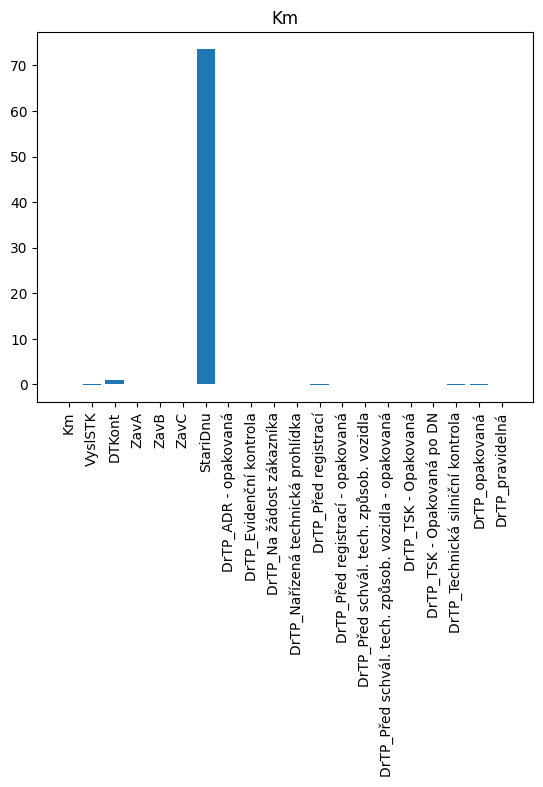

Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


array([-1.47726929e+03,  0.00000000e+00, -1.27281044e-02,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  1.06180550e+02, -4.13091875e-05,
       -7.00449524e-03,  5.18848246e-04,  1.06274798e-04,  2.70075956e-03,
       -1.62639131e-04,  1.97151112e-05,  2.41324251e-05,  3.74556781e-04,
        1.50725187e-04,  1.93163098e-04, -2.31722719e-03,  4.02820529e-03])

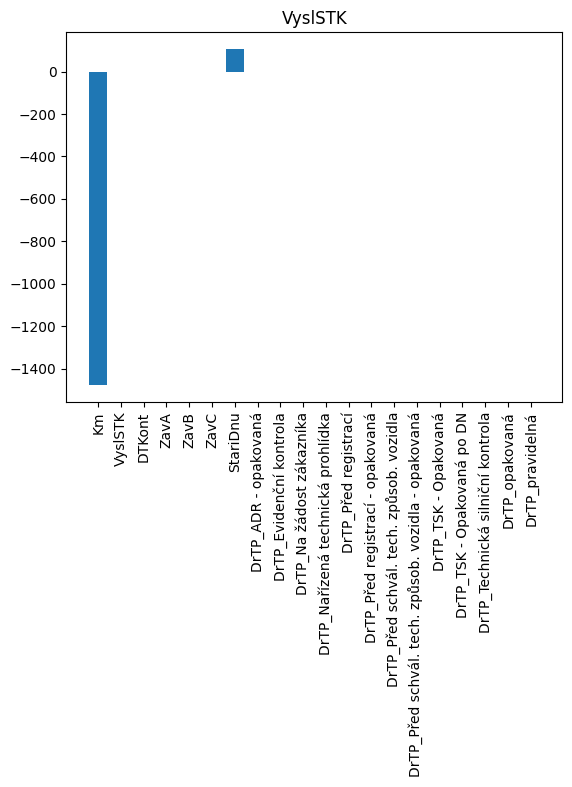

Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


array([ 1.17059287e+04,  3.96828679e-03,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  7.69180984e+01,  1.38318555e-05,
        9.99707915e-03,  7.54131819e-04, -1.94180739e-05,  1.71976874e-03,
        2.86027731e-04,  4.84010758e-04, -6.03660908e-08,  9.64572428e-06,
        7.84297154e-05,  4.82222036e-04,  1.82283169e-03,  3.00834933e-03])

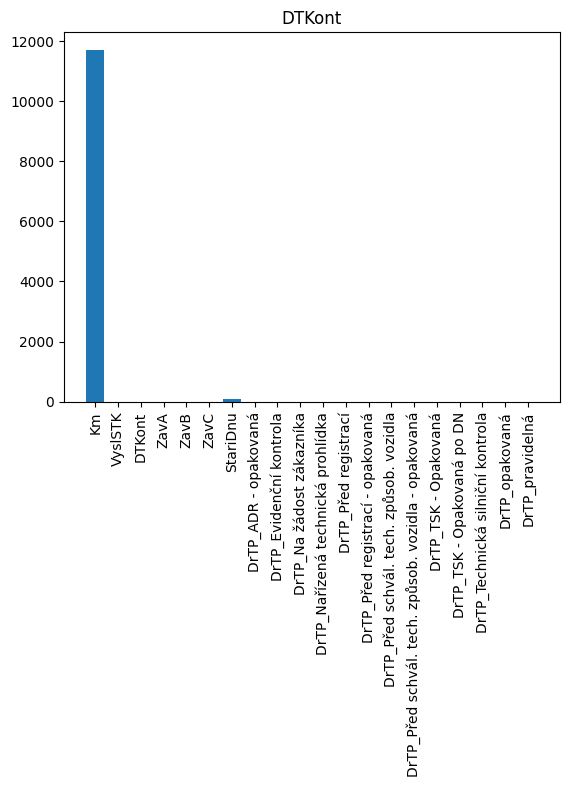

Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


array([-1.07250820e+04, -5.44744451e-03, -4.40655388e-02,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00, -1.42235001e+02, -1.41626160e-05,
       -4.94201668e-03, -1.49080192e-03,  2.77159543e-05, -2.57048546e-03,
       -2.73395854e-04, -5.33980201e-04, -1.61102162e-05, -1.39522410e-04,
       -1.16073308e-04, -4.55281581e-04, -2.04157014e-03, -9.01812501e-03])

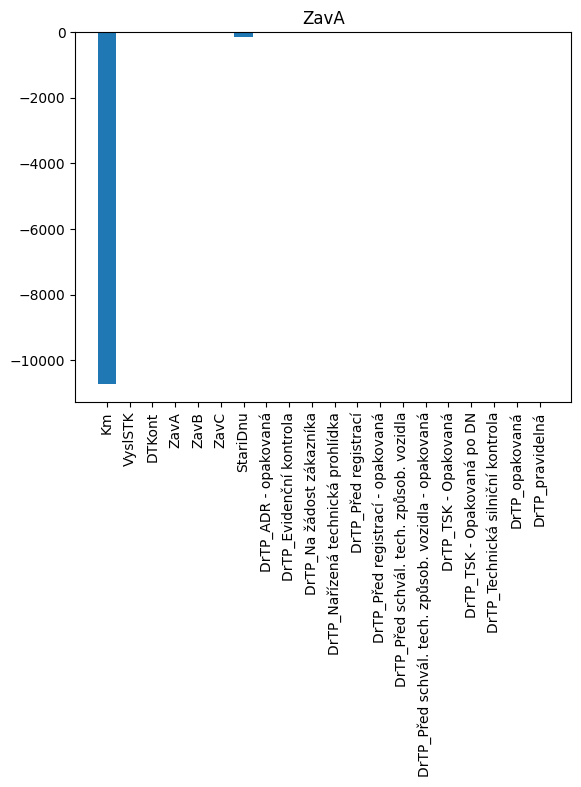

Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


array([-2.02840762e+04, -8.98515712e-03, -5.09184524e-02,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00, -2.64582367e+02,  1.90632018e-05,
        1.68481597e-03, -2.47116177e-03, -1.26359882e-04, -6.88368455e-03,
       -3.22021631e-04, -6.20613981e-04, -1.83965549e-05, -5.73517988e-04,
       -3.23406479e-04, -1.26566284e-03, -1.85315509e-03, -1.54423630e-02])

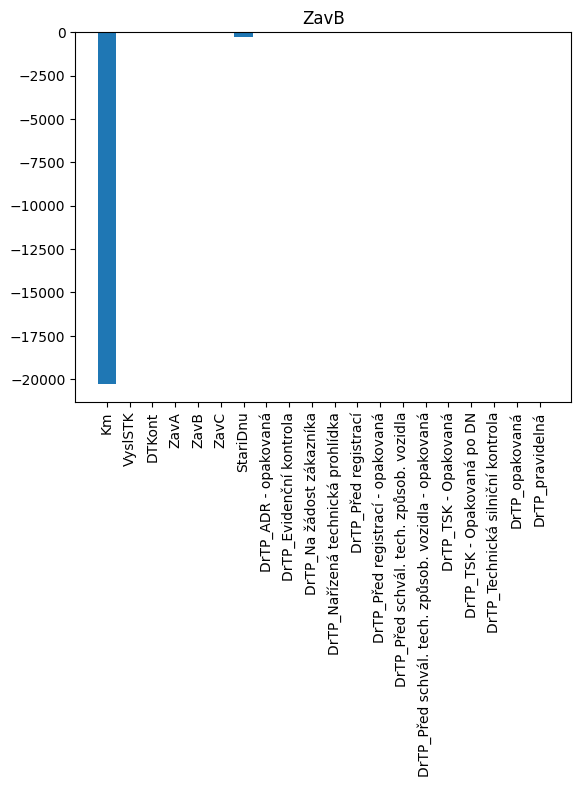

Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


array([ 5.29033875e+02, -1.69303385e-03,  5.15939901e-03,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00, -8.05366058e+01,  7.15666192e-06,
        6.98726252e-03, -1.40663865e-03, -6.69568035e-05, -1.94274995e-03,
        3.86510437e-05, -2.44899638e-05, -2.25709973e-05, -2.72055797e-04,
       -1.28627318e-04, -1.74362256e-04,  1.48661959e-03, -5.51635493e-03])

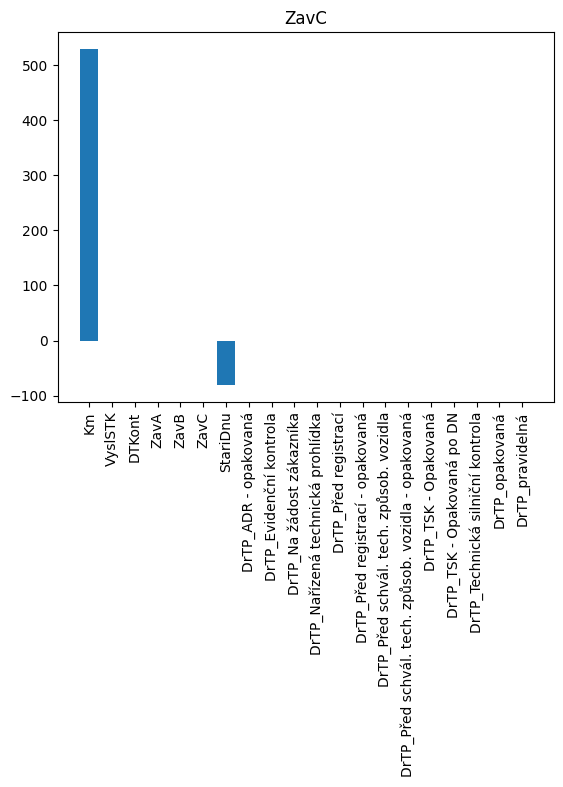

Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


array([ 1.03848484e+05, -2.55796500e-02,  7.32511044e-01,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00, -5.13061997e-04,
       -2.26084571e-02, -1.88695211e-02, -7.89061829e-04, -1.23775005e-02,
       -4.85614780e-03, -2.60293391e-02,  1.21821114e-03, -4.16535127e-04,
       -2.13483023e-03,  1.43815321e-03,  4.20851558e-02,  3.65766197e-01])

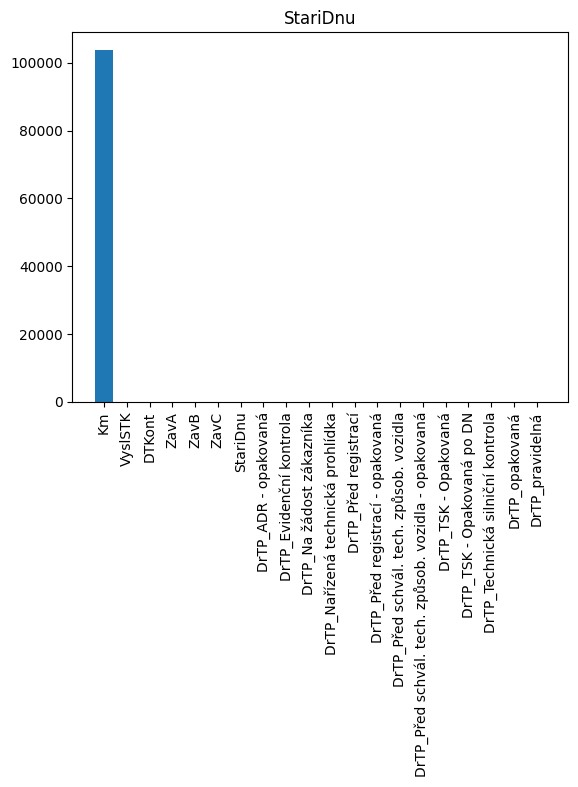

Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


array([-4.30241602e+03, -4.62354906e-03, -1.16022630e-02,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00, -1.30299606e+02,  0.00000000e+00,
        1.13690915e-02, -6.71137532e-04, -5.31065889e-05, -2.49158125e-03,
       -1.37592389e-04, -5.11704129e-04, -2.73019250e-05, -2.65894399e-04,
       -8.71977900e-05, -3.94084782e-04, -1.37532348e-04, -1.35824177e-02])

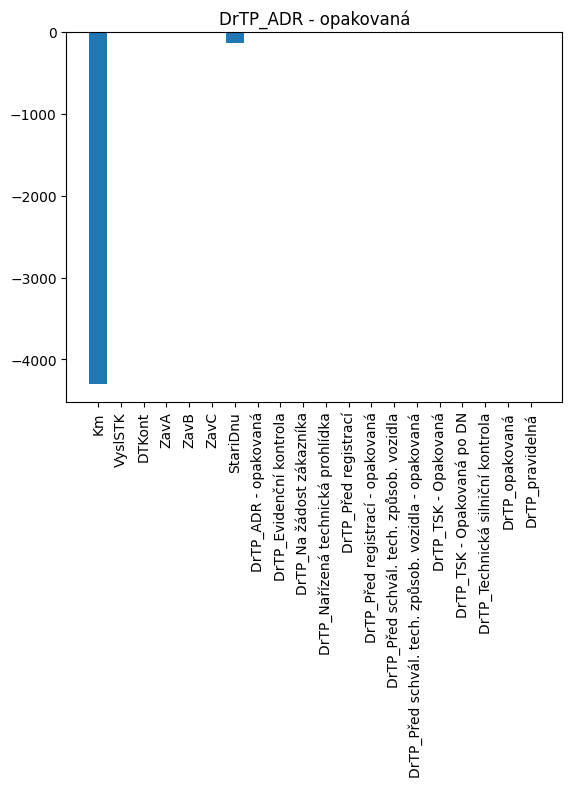

Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


array([ 4.05122119e+03, -8.60042579e-04,  4.12949082e-03,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00, -8.08497524e+00,  2.63774677e-06,
        0.00000000e+00,  1.14941818e-03,  5.85699090e-05,  6.81093486e-04,
        4.46365848e-05, -7.08991138e-05, -9.49985770e-06,  1.38398056e-04,
        5.08880003e-05,  2.51385238e-04,  9.57236276e-04, -1.38379808e-03])

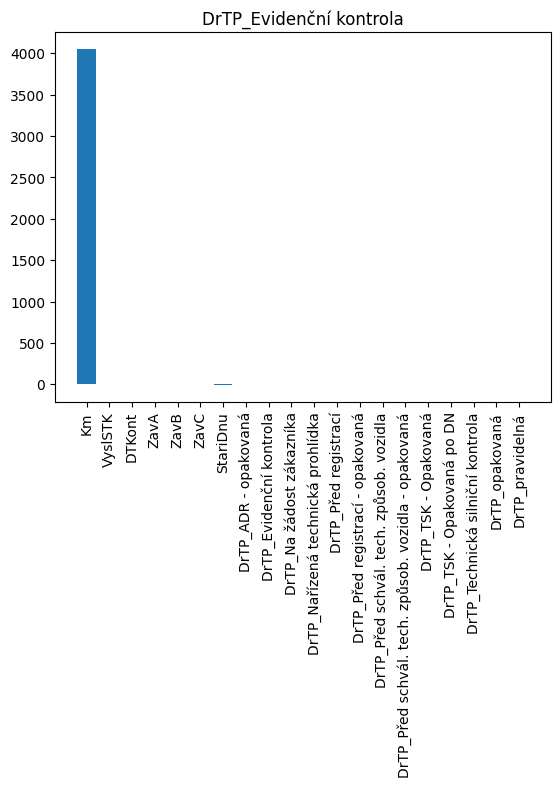

Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


array([ 8.22073242e+03,  4.94226720e-03,  3.70027758e-02,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  1.25159500e+02,  8.57198393e-06,
        3.63095617e-03,  0.00000000e+00, -3.88099324e-05,  1.96973188e-03,
        2.07937497e-04,  4.72269196e-04,  1.87574133e-05,  9.72695998e-05,
        8.64299509e-05,  3.56759178e-04,  1.46454119e-03,  8.32112413e-03])

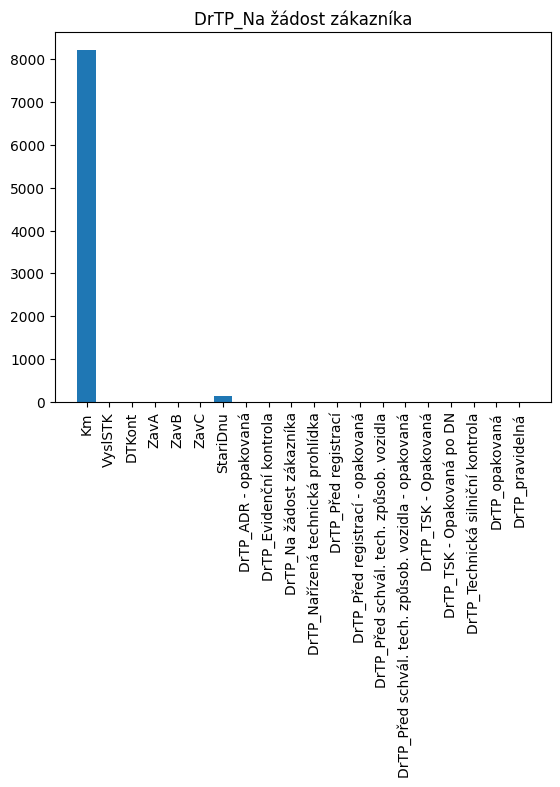

Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


array([-2.54348535e+03,  1.43192607e-04,  5.55985654e-03,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  8.81948352e-01,  2.45782285e-05,
        2.99122534e-03,  1.26050290e-04,  0.00000000e+00, -9.31434333e-04,
        5.40893670e-05,  1.30354805e-04,  1.20736804e-05, -1.01803897e-04,
       -3.50083865e-05, -2.45384319e-04, -3.04718938e-04,  8.02923401e-04])

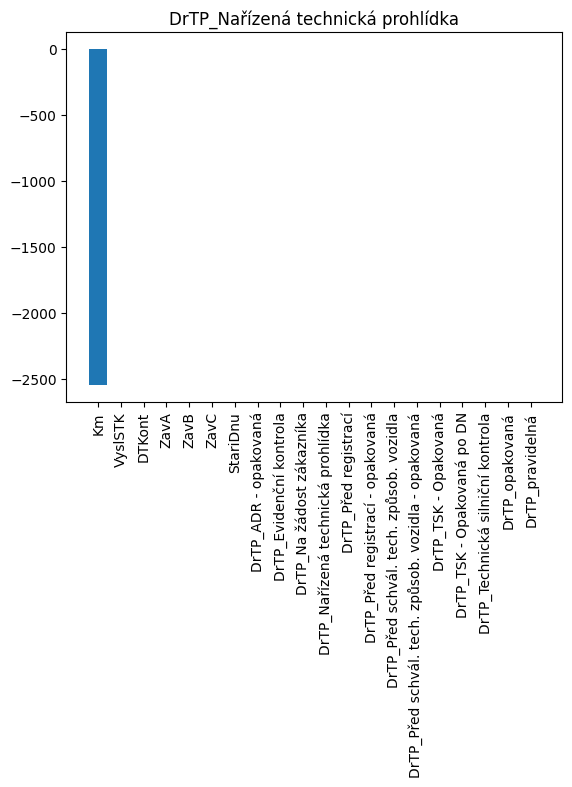

Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


array([-1.16704287e+04, -3.63907078e-03, -3.74553576e-02,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00, -9.29413223e+01, -1.61652097e-05,
       -7.33166421e-03, -1.40099542e-03, -1.11560512e-05,  0.00000000e+00,
       -2.73288286e-04, -3.47489025e-04,  1.94317363e-06, -1.18691853e-04,
       -1.10662433e-04, -5.41007903e-04, -2.05840124e-03, -3.76807409e-03])

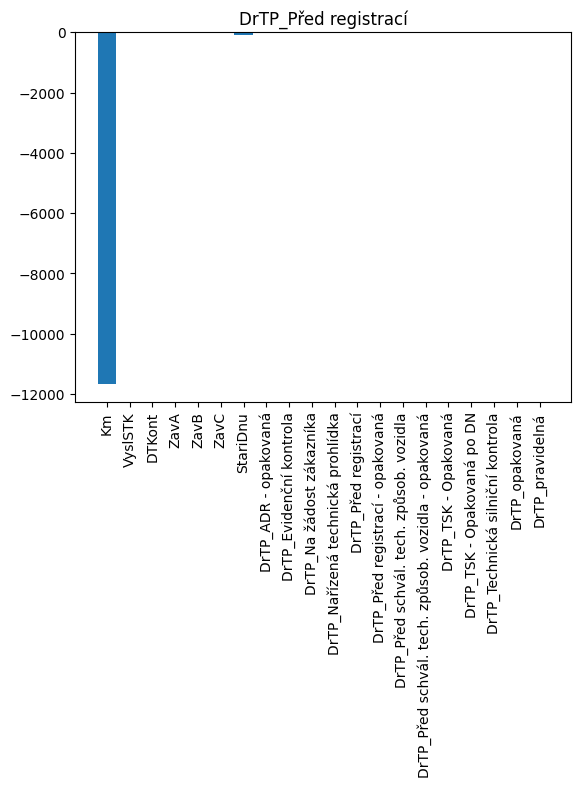

Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


array([ 1.52870557e+04,  9.74373054e-03,  4.36667986e-02,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  3.24580963e+02, -1.24106746e-05,
       -3.21794092e-03,  3.72656598e-03,  1.38531381e-04,  7.64170894e-03,
        0.00000000e+00,  5.96836268e-04,  5.20525282e-05,  7.20523356e-04,
        4.23004822e-04,  1.10386335e-03, -7.12147274e-04,  1.85447000e-02])

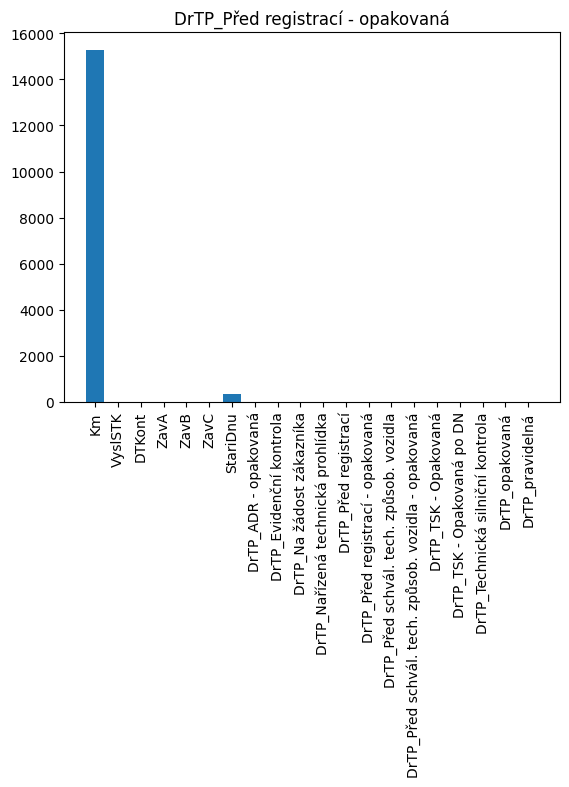

Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


array([ 7.65887354e+03,  2.58707645e-04,  2.00268831e-02,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00, -1.16489000e+01, -4.03969643e-05,
        9.49816778e-03, -6.23084488e-04, -2.66909392e-05,  3.20738502e-04,
       -5.83031351e-06,  0.00000000e+00, -2.61475743e-05, -7.47768645e-05,
        6.72388887e-06,  2.66018615e-04,  2.39814818e-03, -4.76753199e-03])

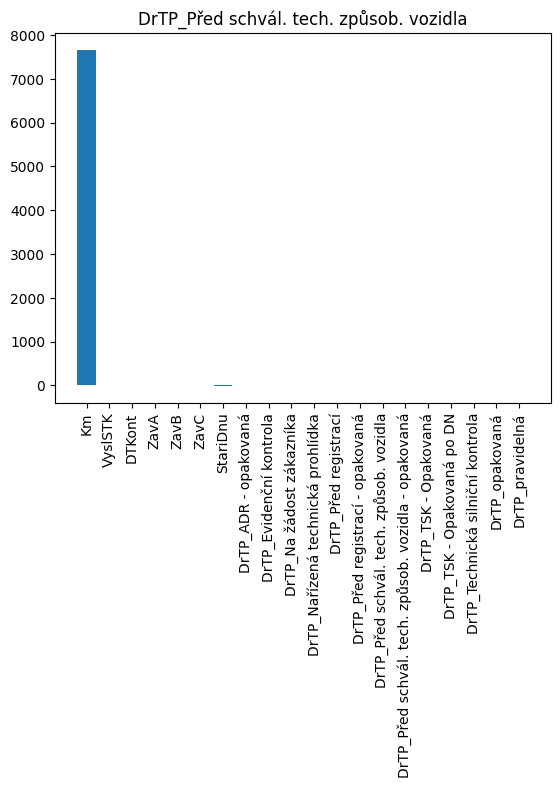

Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


array([-6.50769409e+02, -2.40647187e-03, -1.37565369e-02,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00, -6.80944443e+01, -3.61791135e-05,
        2.10906961e-03, -1.05023303e-03,  2.62398771e-05, -5.83183835e-04,
       -1.52457404e-04, -3.76082695e-04,  0.00000000e+00, -5.67517236e-05,
       -2.72705856e-05, -4.49302661e-06, -7.21219185e-05, -7.18860794e-03])

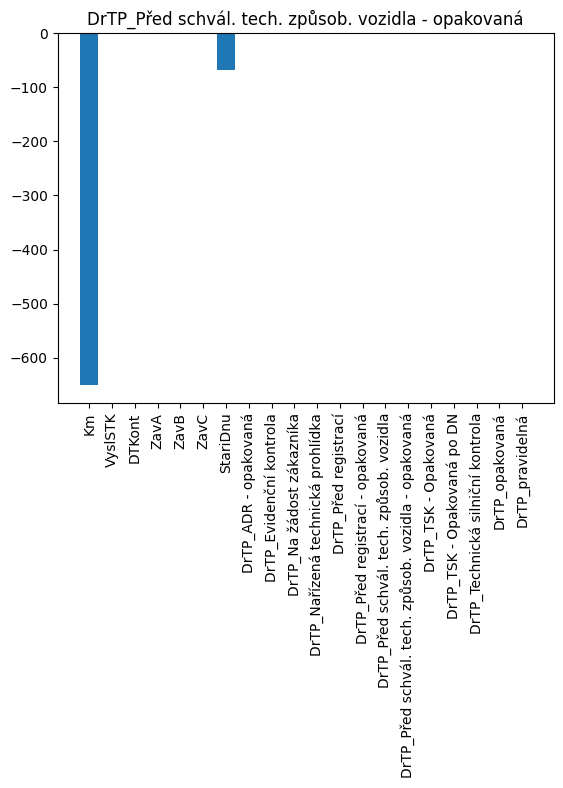

Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


array([ 9.24810938e+03,  9.45964735e-03,  3.20235342e-02,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  3.19499939e+02, -3.92691254e-06,
       -7.87809491e-03,  3.07282247e-03,  1.11292931e-04,  6.58752443e-03,
        1.85043085e-04,  6.42974395e-04,  6.94677947e-05,  0.00000000e+00,
        3.71836941e-04,  8.25864146e-04, -2.00851262e-03,  2.08777580e-02])

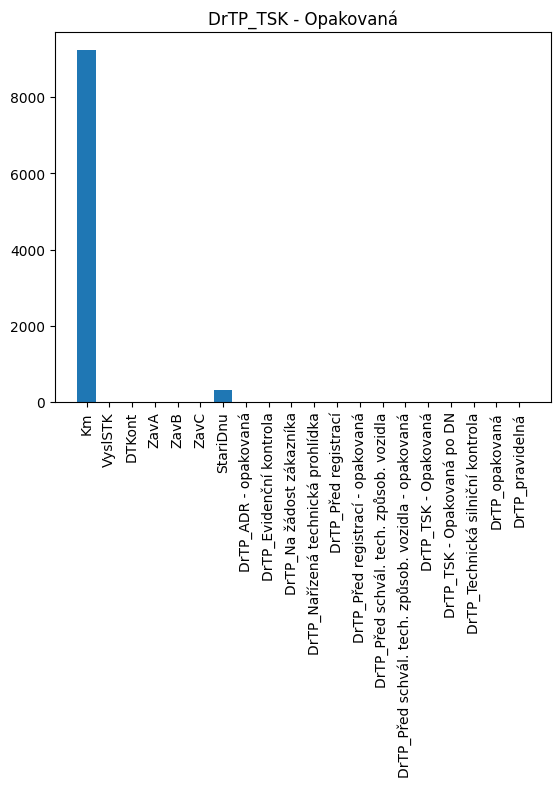

Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


array([-6.78074902e+03, -6.96385978e-03, -2.83859689e-02,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00, -2.30443542e+02, -2.01632865e-05,
        4.71649133e-03, -2.74839276e-03, -6.11076030e-05, -4.53017000e-03,
       -2.23611118e-04, -5.81340806e-04, -5.21776565e-05, -4.55392932e-04,
        0.00000000e+00, -5.37185173e-04,  1.18482334e-03, -1.59499031e-02])

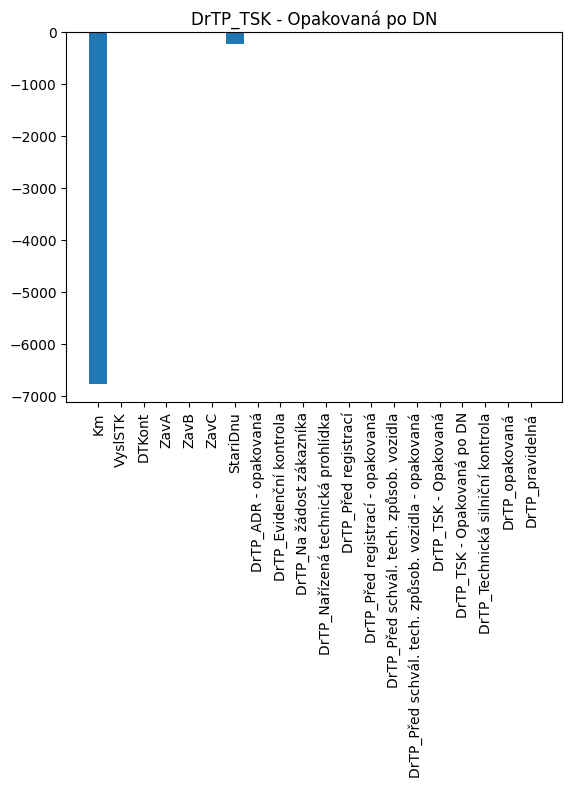

Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


array([-7.41262305e+03, -4.90853097e-03, -1.98141206e-02,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00, -1.55552689e+02, -1.45908562e-05,
        4.58708173e-03, -2.11525545e-03, -8.56506522e-05, -3.80773051e-03,
       -1.99840273e-04, -3.84262006e-04, -2.45872325e-05, -3.65651300e-04,
       -1.89388913e-04,  0.00000000e+00,  1.09318411e-04, -1.08517818e-02])

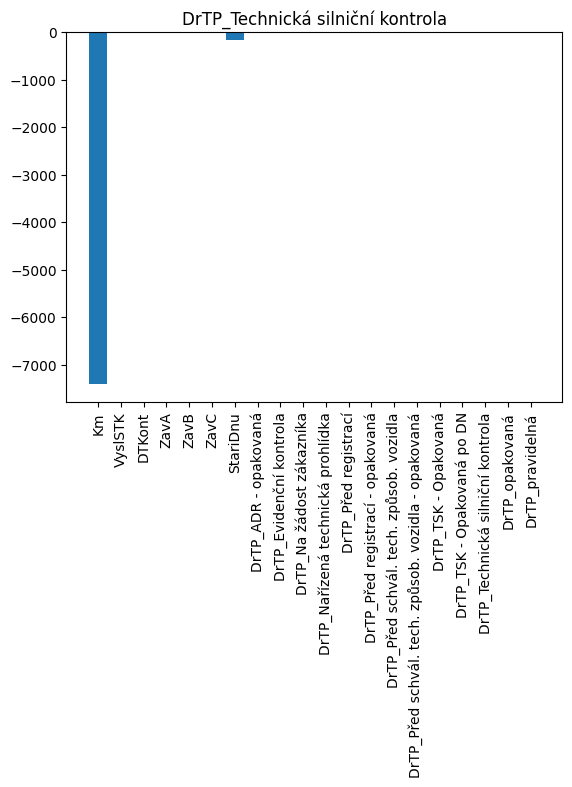

Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


array([ 1.07882676e+04,  8.76879878e-03,  3.88472155e-02,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  3.01129272e+02, -6.80817129e-06,
       -3.79572180e-03,  3.40555795e-03,  8.34435778e-05,  6.11814391e-03,
        2.29031866e-04,  6.04154367e-04,  5.81025779e-05,  5.84737980e-04,
        3.46223882e-04,  7.50000414e-04,  0.00000000e+00,  1.71559416e-02])

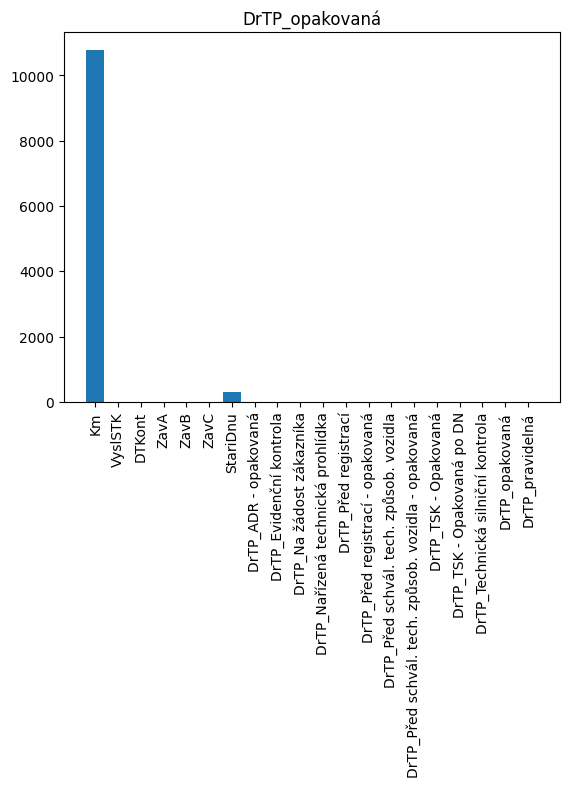

Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


array([-1.07017285e+04, -2.30781012e-03, -2.78964695e-02,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00, -3.79877167e+01, -2.80813219e-06,
       -2.57266243e-03, -1.25173901e-04, -1.01688456e-05, -1.18450599e-03,
       -2.20013448e-04, -3.68634413e-04,  1.60923992e-05, -3.12649317e-05,
       -1.31598081e-05, -4.69335559e-04, -2.92148232e-03,  0.00000000e+00])

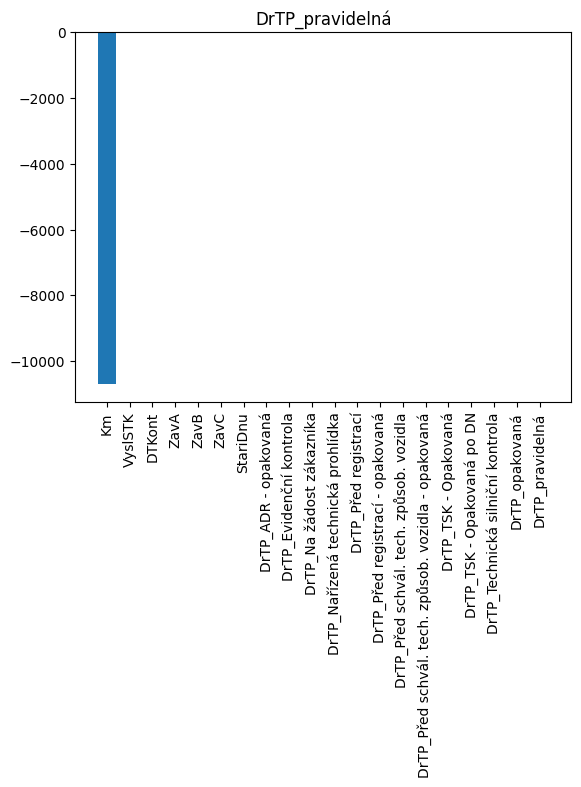

In [14]:
# try explaining a single data point

# pick a data point
dt_index = 500
err_item_props = data['err_list'][dt_index]
err_item = data['dataset'].df.iloc[[err_item_props[0]]]

display(err_item_props)
display(err_item)
# display(torch.tensor(err_item.values))

# get a backup of model parameters
original_params = copy.deepcopy(model.state_dict())

shap_values = []

# explain each feature (only explaing features with a big error later)
for feature_index in range(0, len(err_item.columns)):
    # print(f'{feature_index}: {err_item_props[2][feature_index]}')

    # zero out the "feature_index"th parameter in each neuron
    # of the first layer
    modified_params = copy.deepcopy(model.state_dict())
    for neuron in modified_params['layer_input.weight']:
        neuron[feature_index] = 0
    model.load_state_dict(modified_params)

    # explain
    dex = shap.DeepExplainer(model, sample)
    # shap_values.append(dex.shap_values(torch.tensor(err_item.values).to(device)))
    shap_value = dex.shap_values(torch.tensor(err_item.values).to(device))

    # restore params
    model.load_state_dict(original_params)

    # plot shap_values
    shap_value = shap_value[feature_index][0]
    display(shap_value)
    # display(err_item.values[0][0])

    plt.bar(err_item.columns, height=shap_value)
    plt.title(err_item.columns[feature_index])
    plt.xticks(rotation=90)  
    plt.show()